In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwikrisda","key":"d41b47fc80e04d06ce6141027f6bc3ad"}'}

In [2]:
! mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hasibullahaman/traffic-prediction-dataset
!unzip /content/traffic-prediction-dataset.zip

100% 83.1k/83.1k [00:00<00:00, 515kB/s]
100% 83.1k/83.1k [00:00<00:00, 514kB/s]
Archive:  /content/traffic-prediction-dataset.zip
  inflating: Traffic.csv             
  inflating: TrafficTwoMonth.csv     


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [6]:
data = pd.read_csv('Traffic.csv')
data.info()
print(data)
data.isnull().sum()
Time = data['Time'].values
Total  = data['Total'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB
             Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0     12:00:00 AM    10         Tuesday        31          0         4   
1     12:15:00 AM    10         Tuesday        49          0         3   
2     12:30:00 AM    10         Tuesday        46          0         3   
3     12:45:00 AM    10      

In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, shuffle=False)
train_Total = train_data['Total'].values
val_Total = val_data['Total'].values

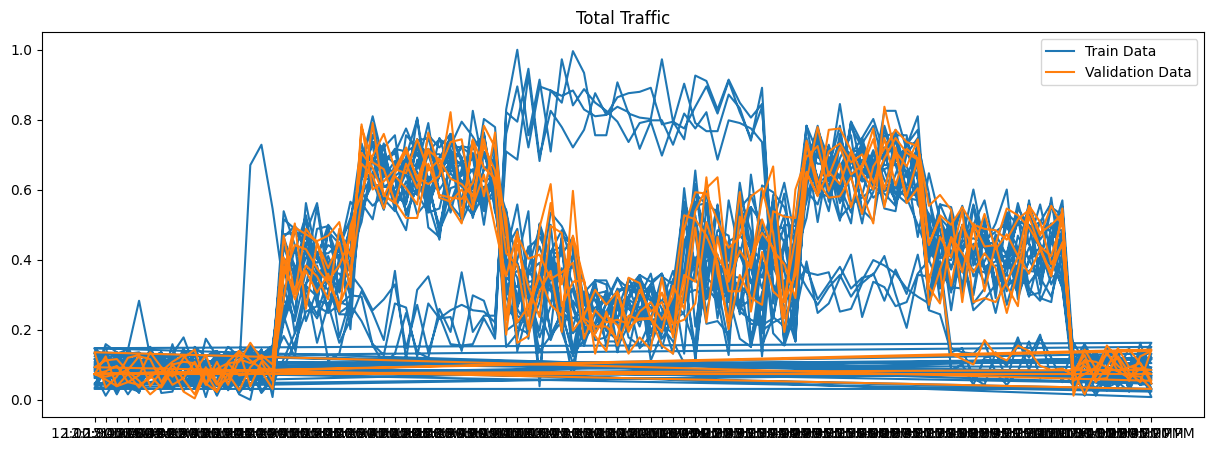

In [8]:
scaler = MinMaxScaler()
train_Total = scaler.fit_transform(train_Total.reshape(-1, 1))
val_Total = scaler.transform(val_Total.reshape(-1, 1))

plt.figure(figsize=(15,5))
plt.plot(train_data['Time'], train_Total, label='Train Data')
plt.plot(val_data['Time'], val_Total, label='Validation Data')
plt.title('Total Traffic')
plt.legend()
plt.show()

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.cast(series, tf.float32)  # Convert to float32
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
train_set = windowed_dataset(train_Total, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(val_Total, window_size=60, batch_size=100, shuffle_buffer=1000)

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
threshold = (train_Total.max() - train_Total.min()) * 10/100
print("Threshold MAE:", threshold)

Threshold MAE: 0.09999999999999998


In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[callback])

Epoch 1/100
24/24 [==============================] - 14s 320ms/step - loss: 0.0284 - mae: 0.1846 - val_loss: 0.0125 - val_mae: 0.1301
Epoch 2/100
24/24 [==============================] - 7s 262ms/step - loss: 0.0127 - mae: 0.1256 - val_loss: 0.0103 - val_mae: 0.1135
Epoch 3/100
24/24 [==============================] - 8s 330ms/step - loss: 0.0114 - mae: 0.1187 - val_loss: 0.0094 - val_mae: 0.1071
Epoch 4/100
24/24 [==============================] - 8s 331ms/step - loss: 0.0104 - mae: 0.1131 - val_loss: 0.0093 - val_mae: 0.1056
Epoch 5/100
24/24 [==============================] - 6s 252ms/step - loss: 0.0102 - mae: 0.1113 - val_loss: 0.0089 - val_mae: 0.1016
Epoch 6/100
24/24 [==============================] - 7s 293ms/step - loss: 0.0096 - mae: 0.1071 - val_loss: 0.0088 - val_mae: 0.1012
Epoch 7/100
24/24 [==============================] - 8s 316ms/step - loss: 0.0094 - mae: 0.1058 - val_loss: 0.0085 - val_mae: 0.0986
Epoch 8/100
24/24 [==============================] - 8s 307ms/step -

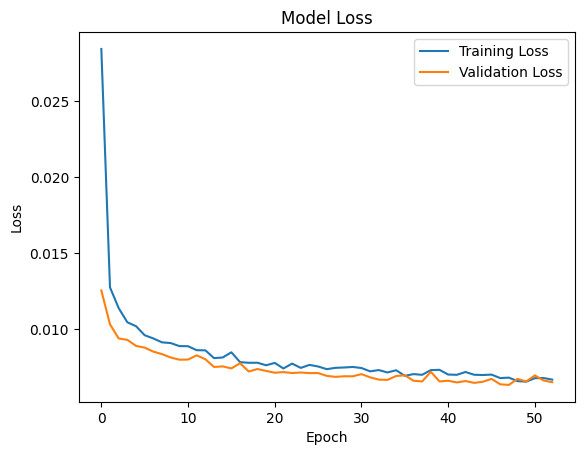

6/6 [==============================] - 2s 212ms/step - loss: 0.0065 - mae: 0.0854
Validation Loss: 0.006495577748864889
Validation MAE: 0.08535734564065933


In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

val_loss, val_mae = model.evaluate(val_set)
print("Validation Loss:", val_loss)
print("Validation MAE:", val_mae)